### Import Libraries

In [ ]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from craft.CRAFT import CRAFT
from craft.image_loader import image_loader, loadImage
from craft.post_process import process_results, save_results 
import matplotlib.pyplot as plt
import torch

### Loading models

In [ ]:
CRAFTmodel = CRAFT(pretrained=True)
CRAFTmodel = torch.nn.DataParallel(CRAFTmodel)
CRAFTmodel.load_state_dict(torch.load("craft/craft_mlt_25k.pth", map_location='cpu'))
CRAFTmodel.eval()

TrOCRModelprocessor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
TrOCRmodel = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten")

### Preprocess input image

In [4]:
# img_filename = "samples/10018.jpg"
img_filename = "samples/10412.jpg"
x, ratio_h, ratio_w = image_loader(img_filename)
x = torch.from_numpy(x).permute(2, 0, 1)
x = x.unsqueeze(0)

### Run CRAFT Model (Text Detection)

In [5]:
with torch.no_grad():
    y, feature = CRAFTmodel(x)

# Get Score and Affinity Map
score_text = y[0,:,:,0].cpu().data.numpy()
score_link = y[0,:,:,1].cpu().data.numpy()

### Text Detection Outputs

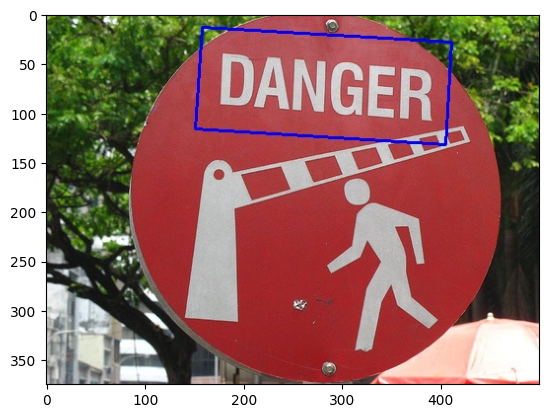

In [9]:
img = loadImage(img_filename)
save_results(img, score_text, score_link, text_threshold=0.2, link_threshold=0.8, low_text=0.1, ratio_h=ratio_h, ratio_w=ratio_w)
y = plt.imread("ouput_image.jpg")
plt.imshow(y)

### Preprocess Results for Text Recognition

In [10]:
results = process_results(img, score_text, score_link, text_threshold=0.1, link_threshold=0.1, low_text=0.4, ratio_h=ratio_h, ratio_w=ratio_w)

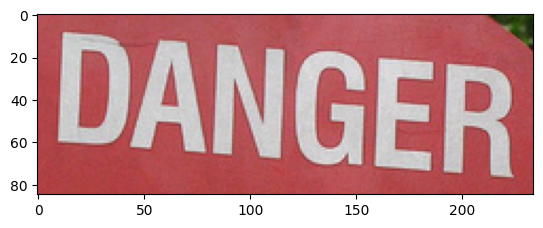

In [11]:
plt.imshow(results[0])

In [13]:
texts = []
for res in results:
    pixel_values = TrOCRModelprocessor(res, return_tensors="pt").pixel_values
    generated_ids = TrOCRmodel.generate(pixel_values)
    generated_text = TrOCRModelprocessor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    texts.append(generated_text)
print(texts)

['danger']
